# **MODEL TESTER**

## Device Selection (GPU/CPU)

In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:",device ,torch.cuda.get_device_name(0)) if device=="cuda" else print("Device:",device)

Device: cuda Tesla V100-PCIE-32GB


## List Available Models.

In [2]:
!ls *.pt Models/

vit_40cls_15epch_Dec10_adam_32bsze.pt  vit_50cls_25epch_Dec12_adam_32bsze.pt
vit_40cls_25epch_Dec11_adam_32bsze.pt  vit_60cls_20epch_Dec12_adam_32bsze.pt
vit_40cls_7epch_Dec10_adam_32bsze.pt   vit_70cls_25epch_Dec17_adam_32bsze.pt

Models/:
vit_10cls_3epch_Dec10_adam_32bsze.pt


## Define Model Path and Image Classes!

In [3]:
model_path = 'Models/vit_10cls_3epch_Dec10_adam_32bsze.pt'
class_names = ['aanachuvadi', 'curry leaves', 'insulin plant', 'kudangal', 'kurumulaku', 'moovila', 'mukooti', 'murikoodi', 'panikoorka', 'sathavari']

class_names = [i.lower() for i in class_names]
print('Total classes',len(class_names))

Total classes 10


## Load Validation Data.

In [4]:
import glob
samples = glob.glob('/home/shabeen/data/Valid_10//*')
samples = sorted(samples)
print('Number of validation data -',len(samples))

Number of validation data - 50


## Find Actual Class Name

In [5]:
# To get the actaul class of an image from the filename based on similarity.
def letter_similarity(word1, word2):
    common_letters1 = set(word1.replace(" ", ""))
    common_letters2 = set(word2.replace(" ", ""))
    #common_score = len(common_letters1.intersection(common_letters2))/(len(common_letters2))
    common_score = (len(common_letters1)+len(common_letters2))/2-len(common_letters1.intersection(common_letters2))
    if word1[0]==word2[0]:
      common_score-=1
    return common_score

def find_most_similar_word(target_word, word_list = class_names):
    most_similar_word = None
    similarity_score = 10

    for word in word_list:
        similarity = letter_similarity(target_word, word)
        if similarity < similarity_score:
            similarity_score = similarity
            most_similar_word = word

    return most_similar_word if similarity_score<5 else 'not_found'

## Model prediction part!

![Image](Performances/vit_10_accuracy_100.0.png)

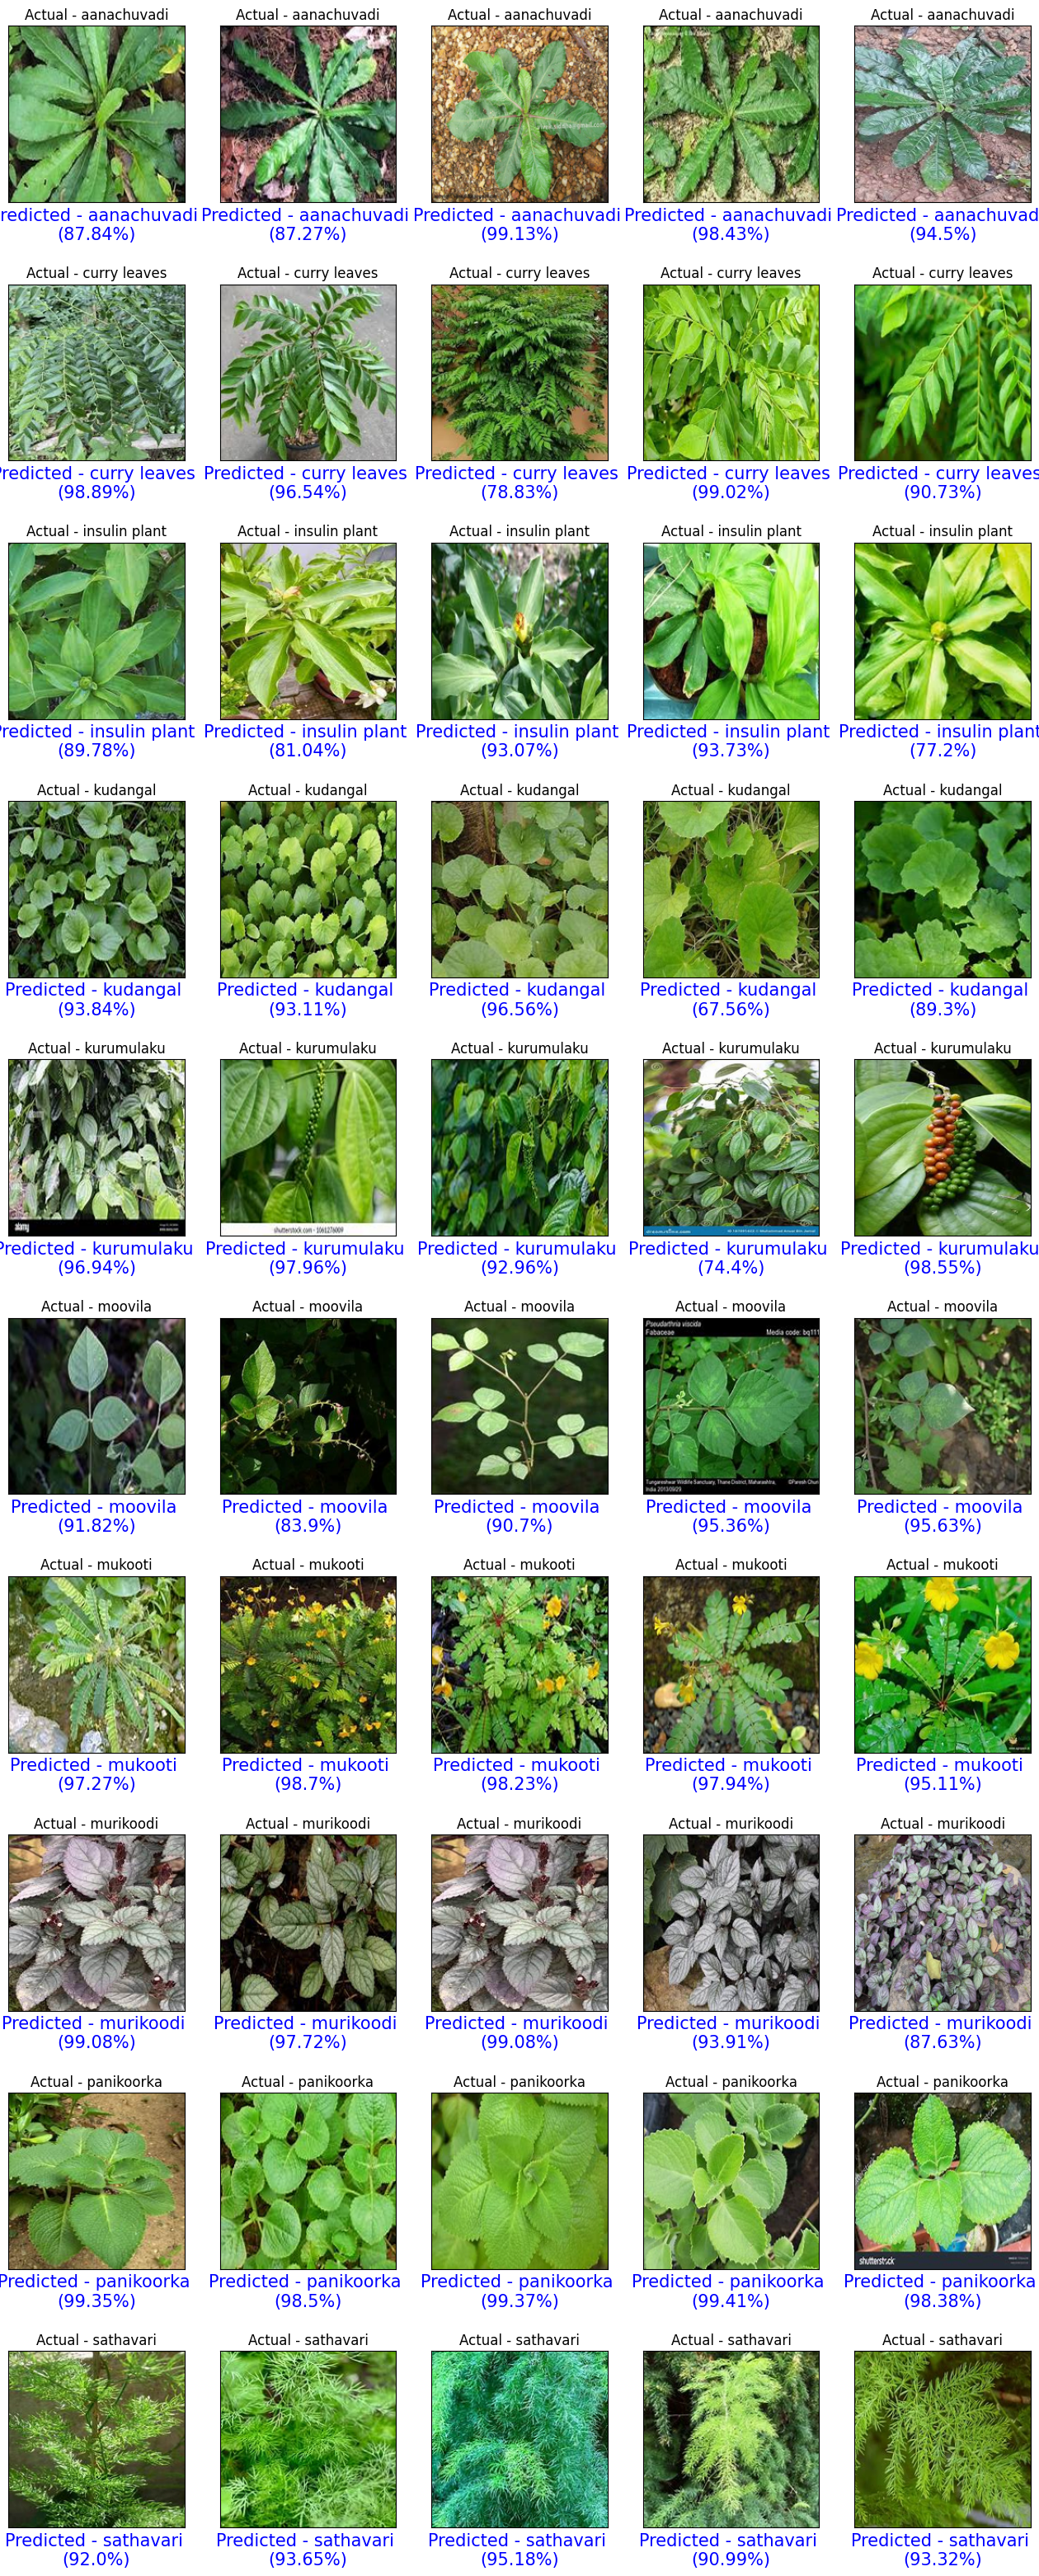

In [6]:
avg_result = True   # Enable Fivecrop and take average prediction.
save_fig = True     # To save the matplotlib figure

import torch
import re
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
from PIL import Image
from torchvision import transforms
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings("ignore")

image_size = (224, 224)

# Image preprocessing.
if not avg_result:
    image_transform = transforms.Compose([
                    transforms.Resize((288,288)),
                    transforms.CenterCrop((224,224)),
                    transforms.ToTensor(),
                    transforms.Lambda(lambda image: image[:3, :, :] if image.shape[0] == 4 else image),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# Image preprocessing with Five crop (if avg_result enabled).    
else:
    image_transform = transforms.Compose([
                    transforms.Resize((312,312)),
                    transforms.FiveCrop((224,224)),
                    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                    transforms.Lambda(lambda image: image[:3, :, :] if image.shape[0] == 4 else image),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# For storing model predictions of each image to calculate performance and accuracy.
acc = {}
actual_class,predicted_class = [],[]

# Model loading, and moving to GPU.
device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.load(model_path, map_location=device)
model.to(device)

# Creating a pyplot figure with size depending on the number of validation images given.
row_numbers = int(np.ceil(len(samples)/5))
plt.ioff()
fig = plt.figure(figsize=(16,row_numbers*4))

# Iterating over the validation images.
for k,image_path in enumerate(samples):
    img = Image.open(image_path)
    # Extracting file name from image path.
    extracted_file_name = re.sub(r"^\d*|[_\d]*$", '',image_path.rsplit("/",1)[1].split(".")[0].lower())
    # Finding most similar class name.
    actual = find_most_similar_word(extracted_file_name)

    # Model prediction.
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0) if not avg_result else image_transform(img)
        target_image_pred = model(transformed_image.to(device))
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Averaging multiple ouputs Using Fivecrop transformation.
    if avg_result:
        # Taking the best 2 model prediction probabilities each from 5 images.
        confidences, indices = torch.topk(target_image_pred_probs, k=2)
        # Finding the most frequent class label.
        unique_elements, counts = indices.unique(return_counts=True)
        values,_ = torch.topk(counts,2)
        most_freq = sorted(list(set(values.tolist())),reverse=True)
        freq_labels = []
        [freq_labels.extend(unique_elements[counts==i].tolist()) for i in most_freq]
        freq_confidences = [confidences[indices==i].mean() for i in freq_labels]

        # Finding the labels that the model predicted with highest confidence.
        firts_pos_scores = [j.item()-torch.where(indices==i)[1].sum().item() for i,j in zip(freq_labels,values)]
        result = list(zip(freq_confidences,freq_labels,firts_pos_scores))
        # Focus on to other metrices if 2 class labels having same frequency or most similar frequency (differnce 1) 
        if len(set(most_freq)) == 1 or most_freq[0]-most_freq[1]<=2:  
            # First give importance to the first positions.(ie, class labels that are predicted with higher confidence by model)
            # If cannot conclude, then take into account the average confidence of each label.
            pos = 2 if len(set(firts_pos_scores)) == len(firts_pos_scores) else 0
            result = sorted(result,key=lambda x:x[pos],reverse=True) 
        confidence = round(result[0][0].item()*100,2)
        label = class_names[result[0][1]]
    # Single model output (default).
    else:
        label = class_names[torch.argmax(target_image_pred_probs, dim=1)]
        confidence = round(torch.max(target_image_pred_probs).item()*100,2)

    # If the model prediction is correct, plot in blue color.
    if actual == label:
      acc[actual] = [1,1] if actual not in acc else np.array(acc[actual])+1
      color = 'blue'
    # If the prediction is wrong, plot in red color.
    else:
      acc[actual] = [0,1] if actual not in acc else np.array(acc[actual])+[0,1]
      color = 'red'

    actual_class.append(actual)
    predicted_class.append(label)

    # Adding the plot to the figure.
    plt.figure(fig)
    plt.subplot(row_numbers,5,k+1)
    img = img.resize((200,200))
    plt.imshow(img)
    plt.title(f'Actual - {extracted_file_name}')
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    plt.xlabel(f'Predicted - {label} \n({confidence}%)',fontdict={'color':color,'size':15})
# Finding overall model accuracy.
accuracy = round(sum([acc[i][0]/acc[i][1] for i in acc])/len(acc),3)*100
# Saving the figure as png file into the Performance folder.
if save_fig:
    fig_path = f"Performances/{model_path.split('/')[-1].split('cls')[0]}_accuracy_{accuracy}.png"
    fig.savefig(fig_path, bbox_inches='tight')

# Display the plot
image_markdown = f"![Image]({fig_path})"
display(Markdown(image_markdown))

## Analysing Model Performance

In [7]:
# Identifying which are the classes that model fails to identify completely, that hasnt predicted once.
actual_classes_unq, predicted_classes_unq = np.unique(actual_class),np.unique(predicted_class)
print('Total Classes in input :',len(actual_classes_unq),'\nTotal Classes in Output :',len(predicted_classes_unq))
not_in_out=set(actual_classes_unq).difference(set(predicted_classes_unq))
print("Classes in the inputs that has'nt predicted out once -",len(not_in_out),"\n",not_in_out)
# print("no.of not found classes :",actual_class.count('not_found'))

Total Classes in input : 10 
Total Classes in Output : 10
Classes in the inputs that has'nt predicted out once - 0 
 set()


In [8]:
# Calculate accuracy for each class label.
import pandas as pd
print("Overall Accuracy -",accuracy,"%",end='\n\n')
df=pd.DataFrame(columns=['class','accuracy','count','True Positive'])
for i in acc:
  pos=len(df)
  df.loc[pos]=[i,np.round(acc[i][0]/acc[i][1],2),acc[i][1],acc[i][0]]
df.sort_values(by='accuracy',ascending=False,inplace=True)
df.reset_index(drop=True,inplace=True)
df

Overall Accuracy - 100.0 %



class  accuracy  count  True Positive
0    aanachuvadi       1.0      5              5
1   curry leaves       1.0      5              5
2  insulin plant       1.0      5              5
3       kudangal       1.0      5              5
4     kurumulaku       1.0      5              5
5        moovila       1.0      5              5
6        mukooti       1.0      5              5
7      murikoodi       1.0      5              5
8     panikoorka       1.0      5              5
9      sathavari       1.0      5              5

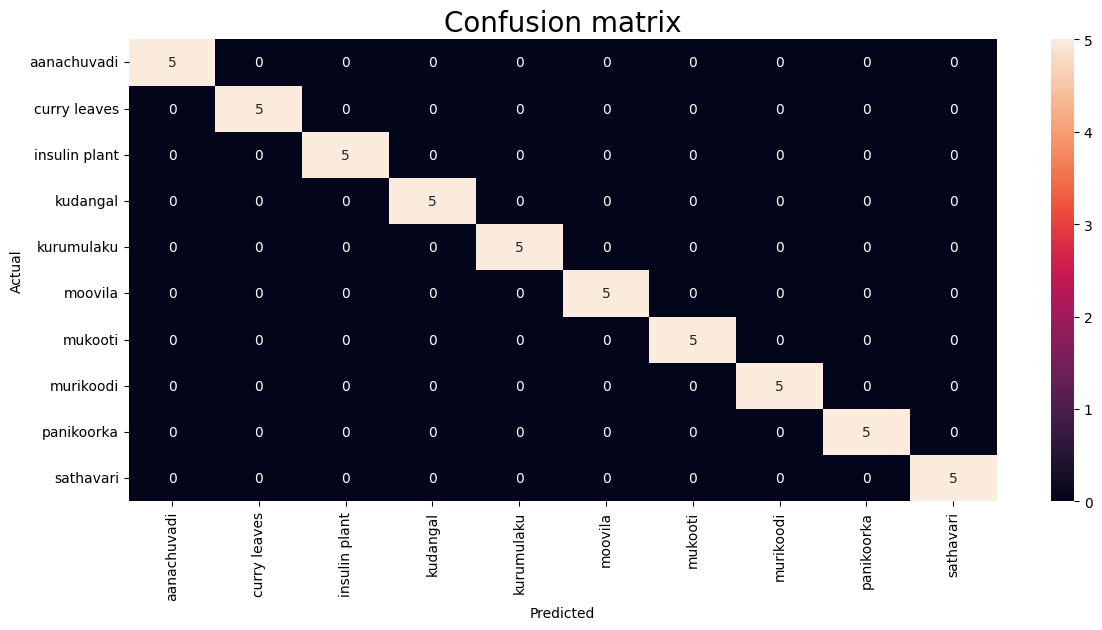

In [9]:
# Plot confusion matrix.
plt.figure(figsize=(14, 6))
total = np.unique(np.hstack((actual_classes_unq,predicted_classes_unq)))
cm = confusion_matrix(actual_class,predicted_class)
sns.heatmap(cm,annot = True,fmt = 'g',xticklabels = total,yticklabels = total);
plt.xlabel('Predicted')
plt.title('Confusion matrix',fontdict = {'size':20});
plt.ylabel('Actual');

In [10]:
print(classification_report(actual_class,predicted_class))

               precision    recall  f1-score   support

  aanachuvadi       1.00      1.00      1.00         5
 curry leaves       1.00      1.00      1.00         5
insulin plant       1.00      1.00      1.00         5
     kudangal       1.00      1.00      1.00         5
   kurumulaku       1.00      1.00      1.00         5
      moovila       1.00      1.00      1.00         5
      mukooti       1.00      1.00      1.00         5
    murikoodi       1.00      1.00      1.00         5
   panikoorka       1.00      1.00      1.00         5
    sathavari       1.00      1.00      1.00         5

     accuracy                           1.00        50
    macro avg       1.00      1.00      1.00        50
 weighted avg       1.00      1.00      1.00        50



--------------------------

## Analysing model's both first and second prediction

In [11]:
device="cpu"
model = torch.load(model_path, map_location=device)
image_size = (224, 224)
image_transform = transforms.Compose([
                transforms.Resize((288,288)),
                transforms.CenterCrop((224,224)),
                transforms.ToTensor(),
                transforms.Lambda(lambda image: image[:3, :, :] if image.shape[0] == 4 else image),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

for i in samples:
    img = Image.open(i)
    extracted_file_name = re.sub(r"^\d*|[_\d]*$", '',i.rsplit("/",1)[1].split(".")[0].lower())
    actual = find_most_similar_word(extracted_file_name)
    model.eval()
    with torch.inference_mode():
            transformed_image = image_transform(img).unsqueeze(dim=0)
            target_image_pred = model(transformed_image)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    confidences,indices=torch.topk(target_image_pred_probs, k=2)
    labels=[class_names[i] for i in indices[0]]
    print("* * "*20)
    sign="" if labels[0]==actual else "---------| CORRECT but SECOND |-----------" if actual in labels else "xxxxxxxxxxxxxx---------| WRONG PREDICTION |-------xxxxxxxxxxxxxxxx"    
    print(sign)
    print(f"Actual - {actual}")
    for l,c in zip(labels,confidences[0]):
        print(f"{l} -- {round(c.item()*100,2)} %")
    # print("* * "*20)
    

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Actual - aanachuvadi
aanachuvadi -- 89.8 %
insulin plant -- 6.41 %
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Actual - aanachuvadi
aanachuvadi -- 85.37 %
insulin plant -- 8.49 %
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Actual - aanachuvadi
aanachuvadi -- 98.85 %
insulin plant -- 0.27 %
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Actual - aanachuvadi
aanachuvadi -- 97.94 %
mukooti -- 0.77 %
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Actual - aanachuvadi
aanachuvadi -- 97.1 %
mukooti -- 1.67 %
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Actual - curry leaves
curry leaves -- 99.01 %
sathavari -- 0.22 %
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

Actual - curry leaves
curry leaves

<span style="color:red">* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *</span>
<span style="color:blue">* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *</span>
